In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.spatial.distance import cosine
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'simcse')))
from sim_utils import load_examples, Inputexample, CustomTextDataset, freeze_layers, test, train    
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoModel, AutoTokenizer

import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
!nvidia-smi

Mon May  2 04:06:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:84:00.0 Off |                  N/A |
| 42%   63C    P2    69W / 250W |   4566MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 22%   

In [3]:
N = 10


train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 16 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 

device =  'cpu' #  torch.device('cuda:3' if torch.cuda.is_available() else 'cpu') 

In [4]:
#['CLINC150','BANKING77','HWU64'] 
test_path = f'../../../HWU64/test/'

# load data
test_samples = load_examples(test_path)


print("===== test set ====")

data = []
labels = []

for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



 # got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

 # get text label of uniqure classes
unique_label = np.unique(np.array(labels))

 # map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== test set ====
Train on Cross Entropy loss
len of dataset : 1076


In [5]:
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased")
config = AutoConfig.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased")
config.num_labels = num_class
config.output_hidden_states = True
model = AutoModelForSequenceClassification.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased",config=config)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at princeton-nlp/unsup-simcse-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
embed_list = []
y = []

In [7]:
for (idx, batch) in enumerate(test_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

        # move parameter to device
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]
        
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)

        
        # Foward pass 
        outputs = model(**inputs,labels=labels)
        
        embeddings = outputs.hidden_states[-1]
        
        #select first token 
        embeddings = embeddings[:,0,:]
        
        embed_list.append(embeddings)
        y.append(labels)

In [8]:
y_list = torch.cat(y,axis=1)

y_list = torch.squeeze(y_list,dim=0)

y_list = y_list.tolist()

In [9]:
len(y_list)

1076

In [11]:
res = torch.cat(embed_list, axis=0)
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 0, n_iter = 3000, metric = 'cosine')
# Fit and transform
embeddings2d = tsne.fit_transform(res.detach().numpy())

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


##  Low dimensional Embedding vectors output from SimCSE : Simple Contrastive Sentence Embeddings Encoder

<AxesSubplot:>

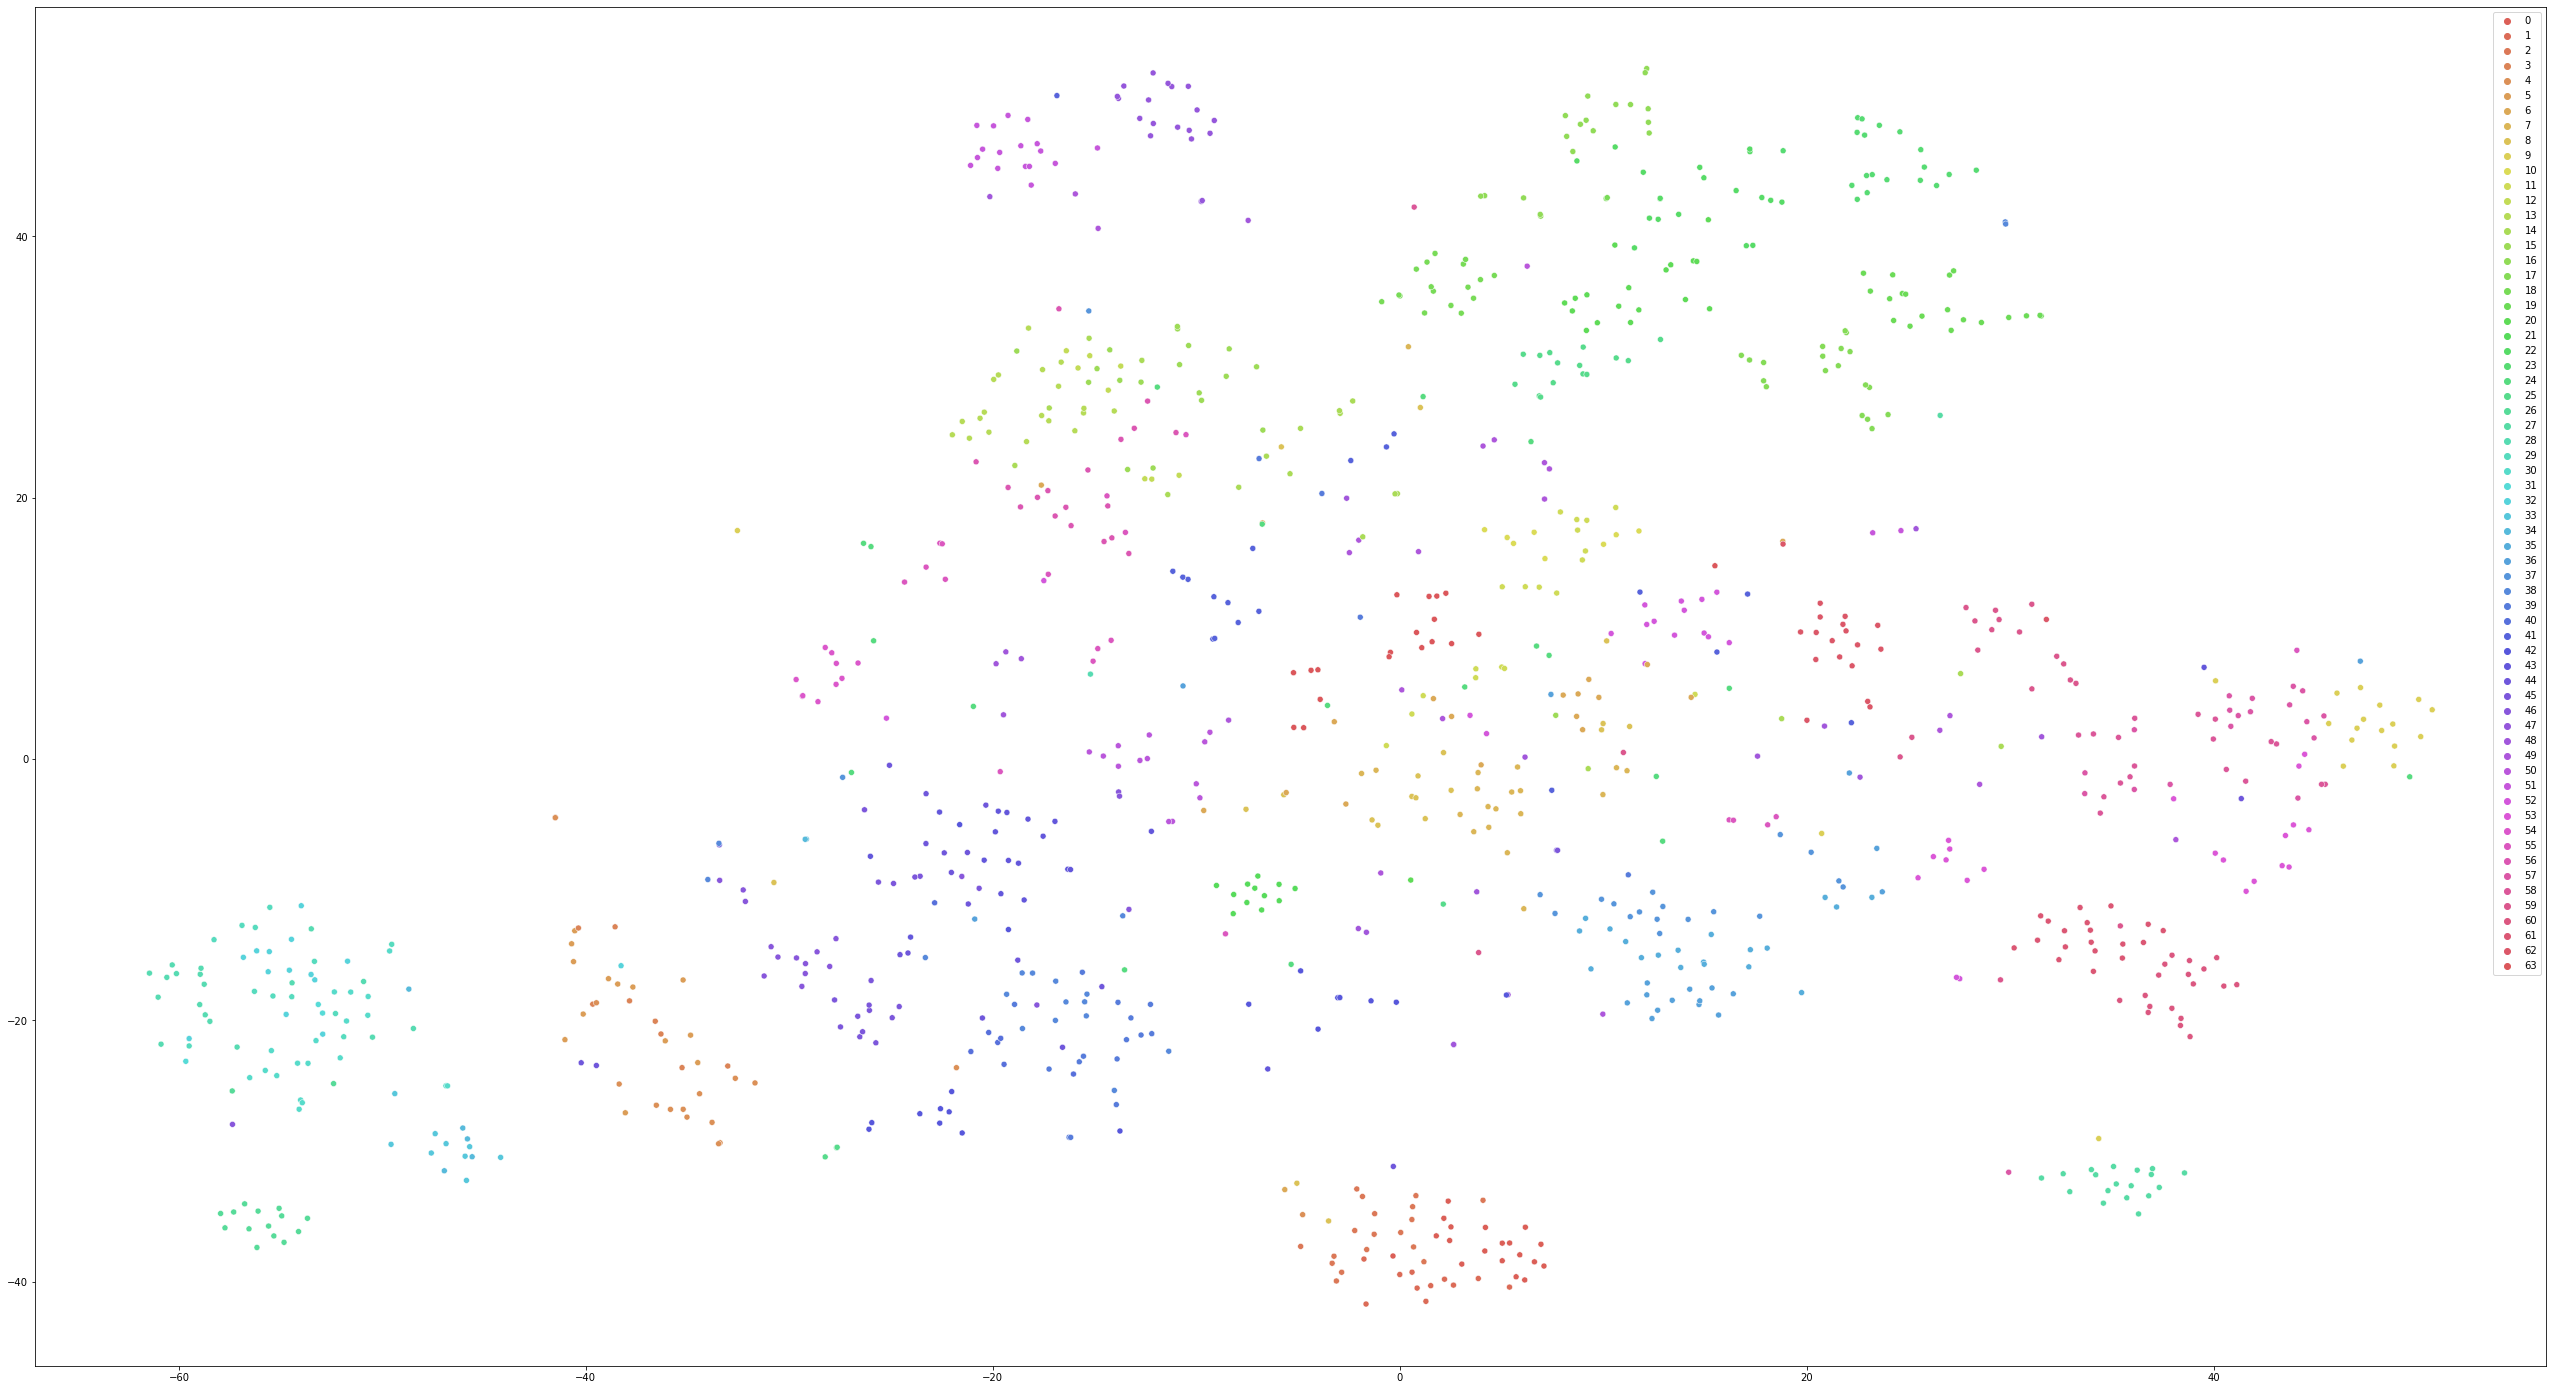

In [13]:
plt.figure(figsize=(45,25))
sns.scatterplot(x=embeddings2d[:,0], y=embeddings2d[:,1], hue=y_list,palette=sns.color_palette("hls", 64))

In [14]:
device

'cpu'

In [15]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_class
config.output_hidden_states = True
model = AutoModelForSequenceClassification.from_pretrained(model_name,config=config)
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [16]:
embed_list = []
y = []

In [17]:
for (idx, batch) in enumerate(test_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

        # move parameter to device
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]
        
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)

        
        # Foward pass 
        outputs = model(**inputs,labels=labels)
        
        embeddings = outputs.hidden_states[-1]
        
        #select first token 
        embeddings = embeddings[:,0,:]
        
        embed_list.append(embeddings)
        y.append(labels)

In [8]:
y_list = torch.cat(y,axis=1)

y_list = torch.squeeze(y_list,dim=0)

y_list = y_list.tolist()

In [18]:
len(y_list)

1076

In [19]:
res = torch.cat(embed_list, axis=0)
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 0, n_iter = 3000, metric = 'cosine')
# Fit and transform
embeddings2d = tsne.fit_transform(res.detach().numpy())

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


##  Low dimensional Embedding vectors Roberta-base

<AxesSubplot:>

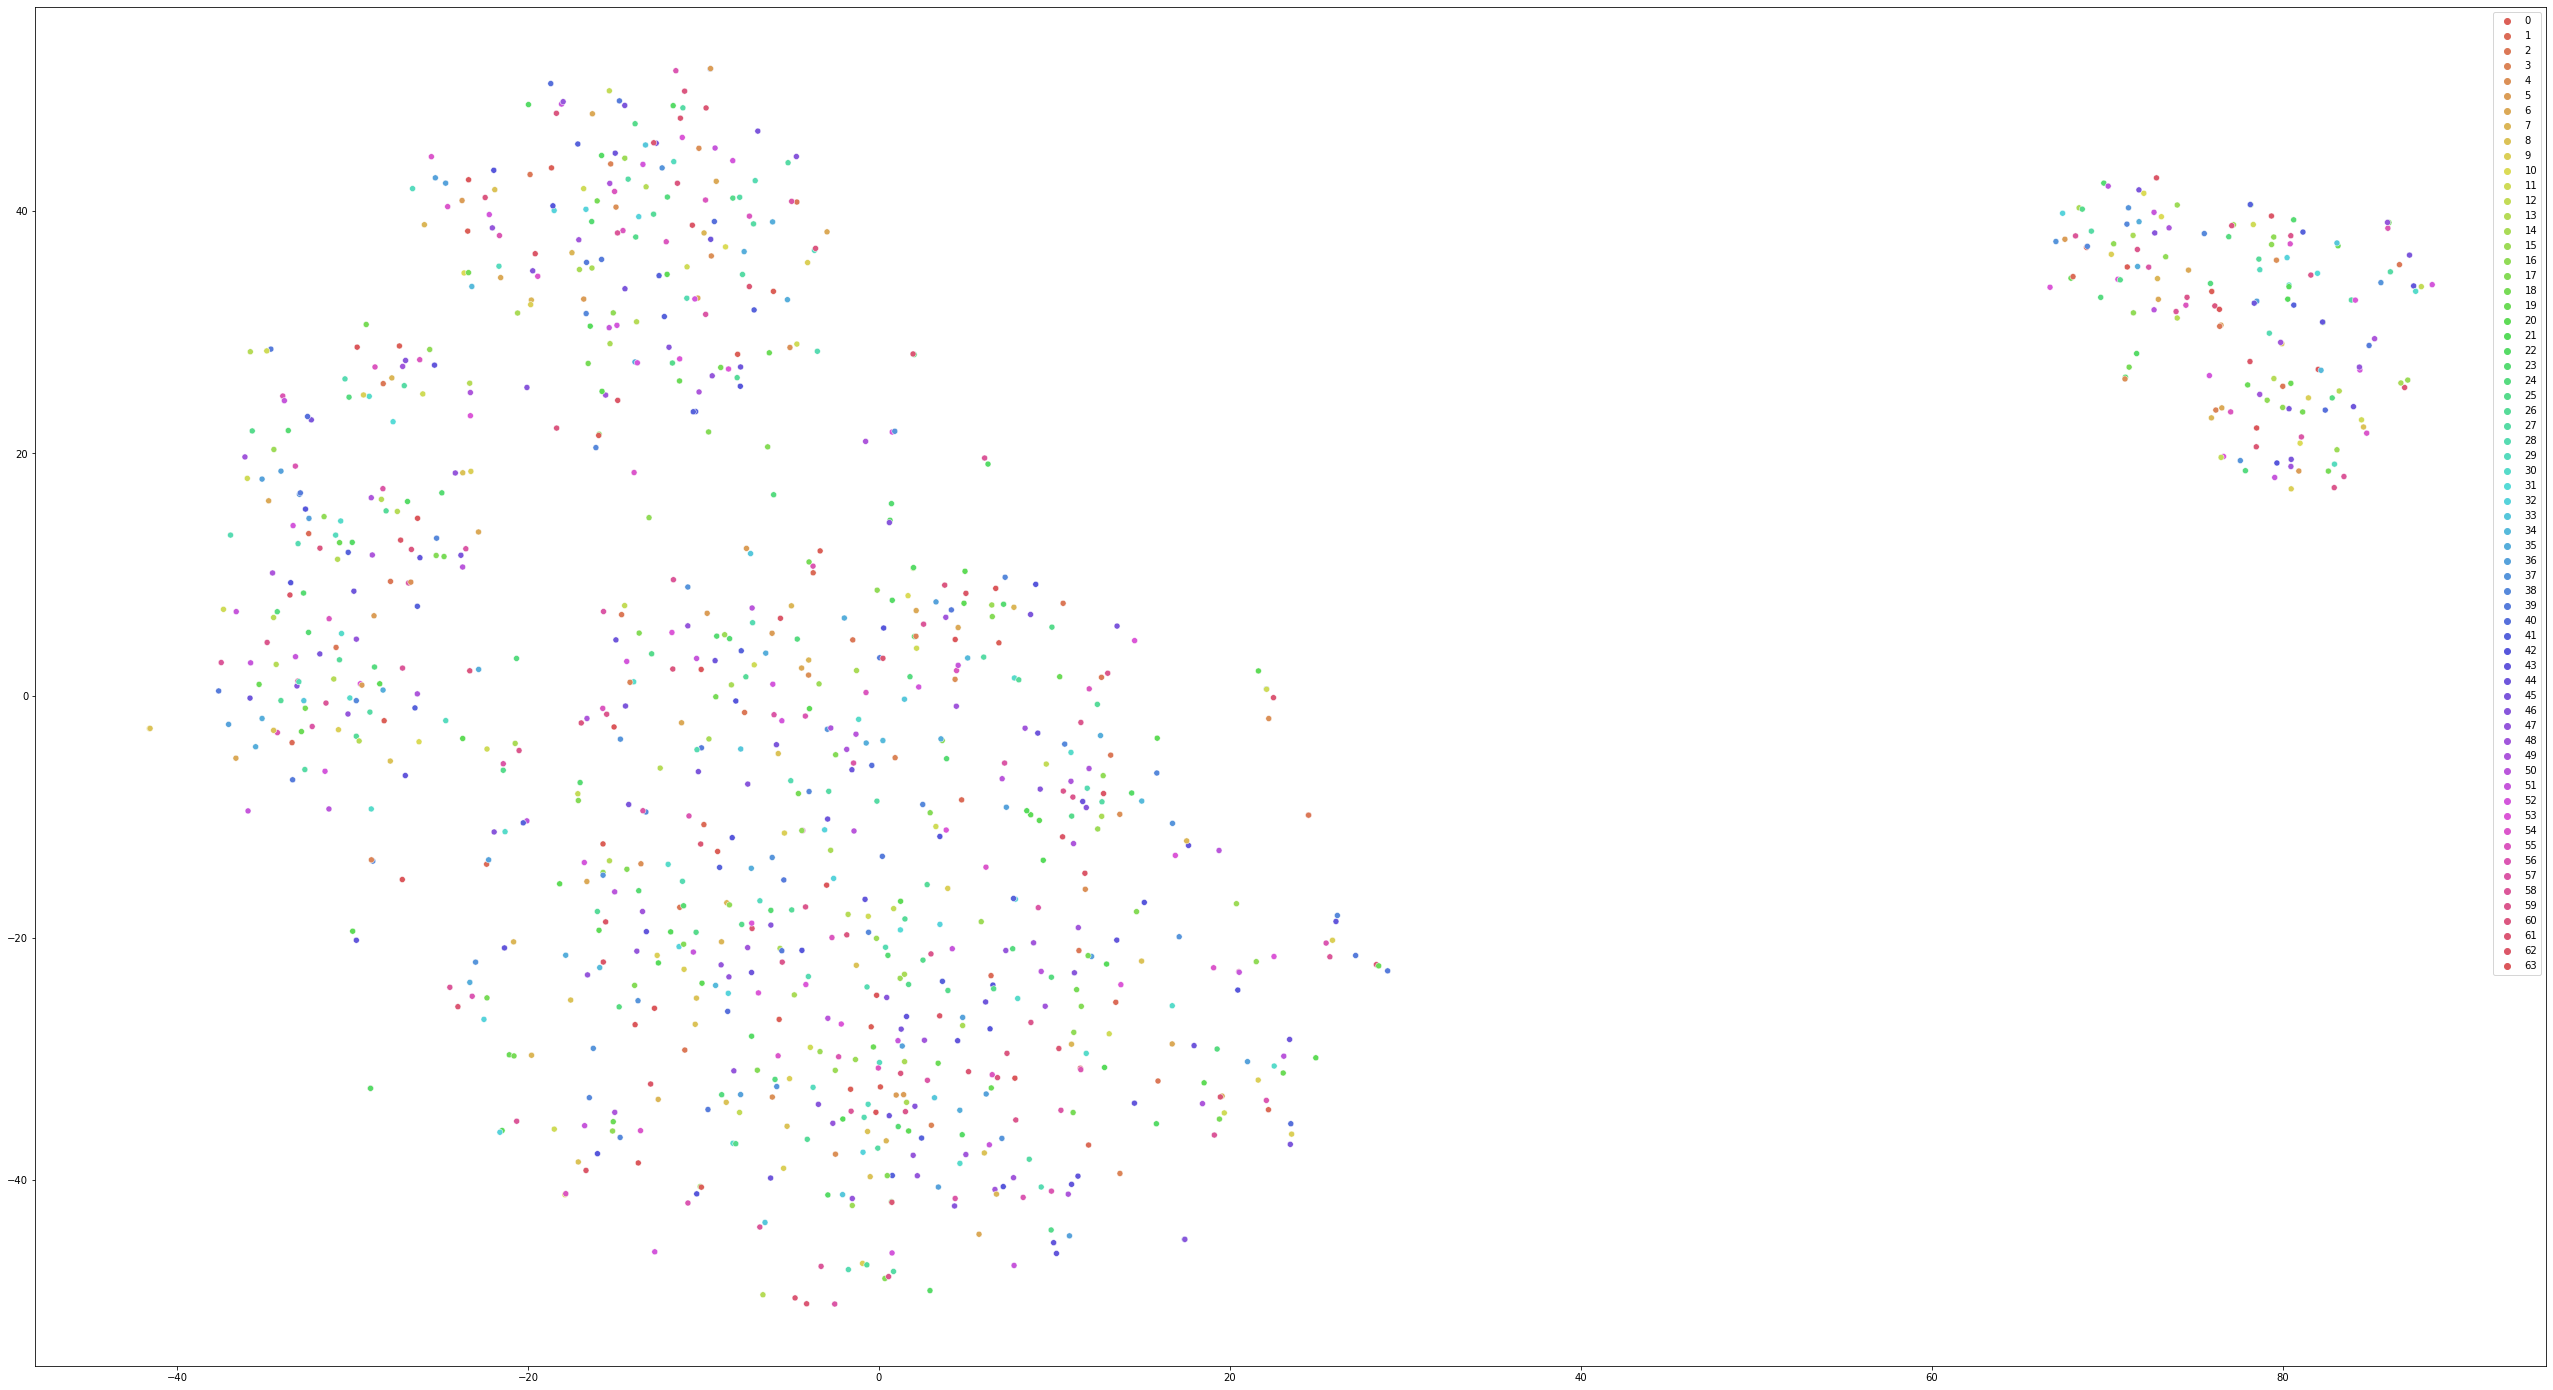

In [20]:
plt.figure(figsize=(45,25))
sns.scatterplot(x=embeddings2d[:,0], y=embeddings2d[:,1], hue=y_list,palette=sns.color_palette("hls", 64))